<a href="https://colab.research.google.com/github/deeplearning-itba/cnn/blob/master/Age_Gender_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Importante!

Antes que nada importar el siguiente link en tu GDrive:

https://drive.google.com/drive/folders/1wYWg5iwc8QbIx5psWuslHBlpnUGjkvmJ?usp=sharing

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
! ls '/content/drive/My Drive/imdb/imgs/'

00  05	10  15	20  25	30  35	40  45	50  55	60  65	70  75	80  85	90  95
01  06	11  16	21  26	31  36	41  46	51  56	61  66	71  76	81  86	91  96
02  07	12  17	22  27	32  37	42  47	52  57	62  67	72  77	82  87	92  97
03  08	13  18	23  28	33  38	43  48	53  58	63  68	73  78	83  88	93  98
04  09	14  19	24  29	34  39	44  49	54  59	64  69	74  79	84  89	94  99


In [0]:
DATASET_PATH = '/content/drive/My Drive/imdb/'
IMAGES_PATH = DATASET_PATH + 'imgs/'

In [0]:
train_df = pd.read_csv(DATASET_PATH + 'train.csv')
valid_df = pd.read_csv(DATASET_PATH + 'val.csv')

In [17]:
train_df.head()

,filename,age,gender
0,12/nm0960912_rm4001085952_1987-1-7_2010.jpg,23,0
1,02/nm0001602_rm2274138368_1967-10-5_2006.jpg,38,1
2,06/nm0004906_rm4277700608_1973-11-26_2009.jpg,35,1
3,60/nm0000160_rm3884488704_1970-11-6_2001.jpg,30,1
4,20/nm0000120_rm1480503296_1962-1-17_2008.jpg,46,1


In [19]:
img = Image.open(IMAGES_PATH + train_df.iloc[0].filename)
img.width, img.height

(224, 224)

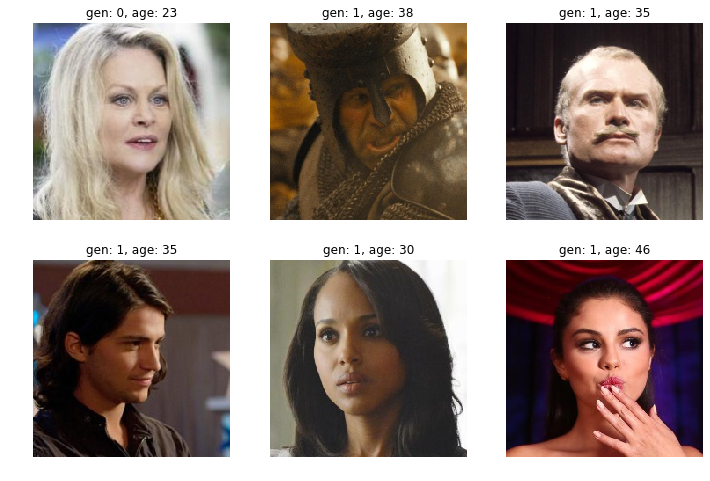

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(12,8))
for row in range(2):
    for col in range(3):
        img_idx = row*2 + col
        img = Image.open(IMAGES_PATH + train_df.iloc[img_idx + np.random.randint(1000)].filename)
        axs[row, col].imshow(img)
        axs[row, col].axis('off')
        axs[row, col].set_title(f'gen: {train_df.iloc[img_idx].gender}, age: {train_df.iloc[img_idx].age}')

In [0]:
train_df['age'] = train_df['age'] / 100
valid_df['age'] = valid_df['age'] / 100

In [22]:
train_df.head()

,filename,age,gender
0,12/nm0960912_rm4001085952_1987-1-7_2010.jpg,0.23,0
1,02/nm0001602_rm2274138368_1967-10-5_2006.jpg,0.38,1
2,06/nm0004906_rm4277700608_1973-11-26_2009.jpg,0.35,1
3,60/nm0000160_rm3884488704_1970-11-6_2001.jpg,0.30,1
4,20/nm0000120_rm1480503296_1962-1-17_2008.jpg,0.46,1


# Generators

In [0]:
BATCH_SIZE = 32

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGES_PATH,
        x_col='filename',
        y_col=['age', 'gender'],
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='multi_output')

Found 137469 validated image filenames.


In [25]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=IMAGES_PATH,
        x_col='filename',
        y_col=['age', 'gender'],
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='multi_output')

Found 34383 validated image filenames.


In [0]:
X, y = next(valid_generator)

In [27]:
X.shape

(32, 224, 224, 3)

In [28]:
y[0], y[1]

(array([0.27, 0.72, 0.29, 0.39, 0.31, 0.44, 0.29, 0.2 , 0.31, 0.27, 0.31,
        0.51, 0.4 , 0.32, 0.32, 0.7 , 0.37, 0.28, 0.45, 0.35, 0.25, 0.22,
        0.49, 0.25, 0.39, 0.14, 0.31, 0.63, 0.43, 0.47, 0.42, 0.29]),
 array([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 0]))

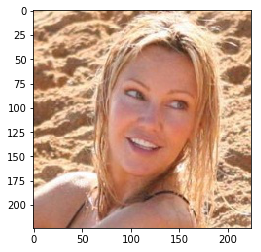

In [29]:
plt.imshow(X[0])
plt.show()

# Model

In [0]:
cnn = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

In [54]:
cnn.output.shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(1280)])

In [0]:
for layer in cnn.layers:
    layer.trainable = False

In [0]:
flatten = Flatten()(cnn.output)
dense_layer = Dense(256)(flatten)
dense_layer = Dense(256)(flatten)
gender_layer = Dense(1, activation='sigmoid', name='gender')(dense_layer)

In [0]:
model = Model(inputs=cnn.input, outputs=[age_layer, gender_layer])

In [67]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
losses = {
    'age':    'mse',
    'gender': 'binary_crossentropy',
}

loss_weights = {
    'age':    0.1,
    'gender': 5.0,    
}

In [0]:
adam = Adam(lr=.001)

In [0]:
model.compile(optimizer=adam, loss=losses, metrics=['accuracy'], loss_weights=loss_weights)

In [0]:
hist = model.fit_generator(
                train_generator,
                steps_per_epoch=train_generator.samples / BATCH_SIZE,
                epochs = 50,
                validation_data  = valid_generator,
                validation_steps = valid_generator.samples / BATCH_SIZE,
                verbose=1,
        )

Epoch 1/50
1471/4295 [=========>....................] - ETA: 7:35 - loss: 44.0467 - age_loss: 0.7973 - gender_loss: 8.7934 - age_acc: 2.1244e-05 - gender_acc: 0.4544